In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)


epochs = 10


# ======= Hyperparams =======
num_words = 50000
maxlen = 500
batch_size = 64
embedding_dim = 256
hidden_dim = 512
num_layers = 2
dropout_prob = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======= Load IMDb Data =======
dataset_path = "./imdb.npz"  # Ensure imdb.npz is in the same directory as your notebook
(x_train, y_train), (x_test, y_test) = imdb.load_data(path=dataset_path, num_words=num_words)

x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

x_train_tensor = torch.tensor(x_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"num_words: {num_words}, maxlen: {maxlen}, Using device: {device}")

num_words: 50000, maxlen: 500, Using device: cuda


# RNN Model

Epoch 1: Train Accuracy=0.5096, Test Accuracy=0.5000 | Train Loss=0.7746, Test Loss=0.7136
Epoch 2: Train Accuracy=0.5132, Test Accuracy=0.6154 | Train Loss=0.7766, Test Loss=0.6650
Epoch 3: Train Accuracy=0.5463, Test Accuracy=0.7060 | Train Loss=0.7535, Test Loss=0.6021
Epoch 4: Train Accuracy=0.7596, Test Accuracy=0.8216 | Train Loss=0.5265, Test Loss=0.4222
Epoch 5: Train Accuracy=0.8488, Test Accuracy=0.8340 | Train Loss=0.3787, Test Loss=0.3808
Epoch 6: Train Accuracy=0.8986, Test Accuracy=0.8421 | Train Loss=0.2812, Test Loss=0.3803
Epoch 7: Train Accuracy=0.9220, Test Accuracy=0.8478 | Train Loss=0.2249, Test Loss=0.3968
Epoch 8: Train Accuracy=0.9327, Test Accuracy=0.8485 | Train Loss=0.1924, Test Loss=0.4771
Epoch 9: Train Accuracy=0.9535, Test Accuracy=0.8440 | Train Loss=0.1455, Test Loss=0.5271
Epoch 10: Train Accuracy=0.9668, Test Accuracy=0.8470 | Train Loss=0.1096, Test Loss=0.4582

Final Evaluation on Test Set:
Accuracy : 0.8470
Precision: 0.8598
Recall   : 0.8293
F1 S

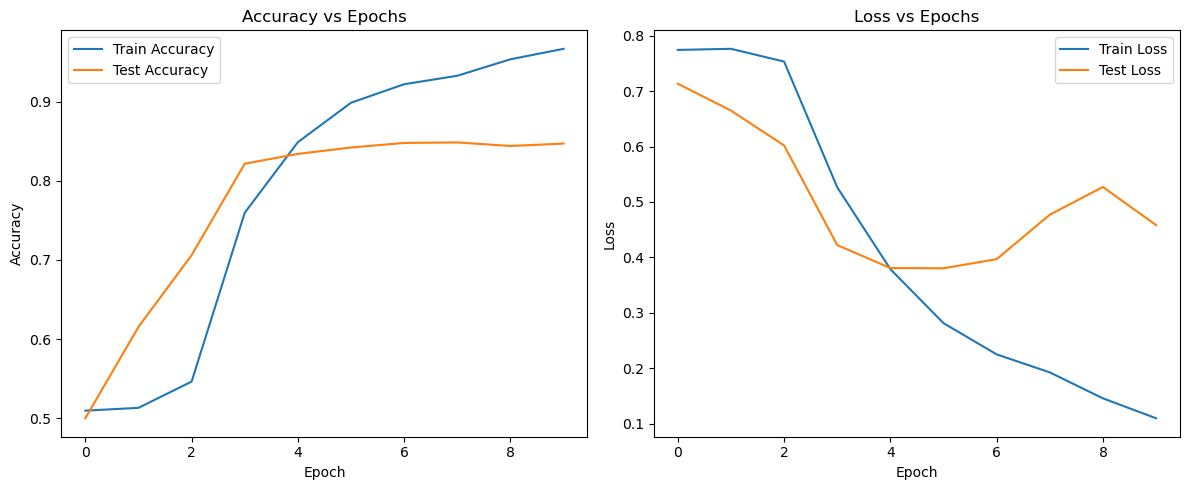

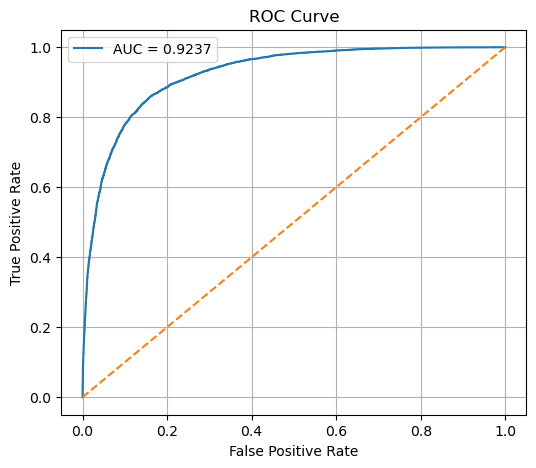

In [3]:
# ======= Improved RNN Model =======
class RNN_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.5):
        super(RNN_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        
        # Bidirectional RNN will have 2*hidden_dim features
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()
        
        # Initialize weights for better convergence
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]
        
        # RNN forward pass
        output, _ = self.rnn(embedded)  # [batch, seq_len, 2*hidden_dim]
        
        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, 2*hidden_dim]
        
        # Apply dropout before final layer
        pooled = self.dropout(pooled)
        
        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
model = RNN_Model(num_words, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# ======= Train & Evaluate =======
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        probs = model(x)
        loss = criterion(probs, y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist.append(test_acc)
    
    # Update scheduler based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# LSTM Model

Epoch 1: Train Accuracy=0.6359, Test Accuracy=0.8178 | Train Loss=0.5987, Test Loss=0.4125
Epoch 2: Train Accuracy=0.8662, Test Accuracy=0.8476 | Train Loss=0.3296, Test Loss=0.3499
Epoch 3: Train Accuracy=0.9135, Test Accuracy=0.8583 | Train Loss=0.2313, Test Loss=0.3360
Epoch 4: Train Accuracy=0.9358, Test Accuracy=0.8590 | Train Loss=0.1862, Test Loss=0.3716
Epoch 5: Train Accuracy=0.9492, Test Accuracy=0.8517 | Train Loss=0.1490, Test Loss=0.4077
Epoch 6: Train Accuracy=0.9697, Test Accuracy=0.8557 | Train Loss=0.0960, Test Loss=0.4183
Epoch 7: Train Accuracy=0.9776, Test Accuracy=0.8371 | Train Loss=0.0766, Test Loss=0.5669
Epoch 8: Train Accuracy=0.9838, Test Accuracy=0.8510 | Train Loss=0.0552, Test Loss=0.5238
Epoch 9: Train Accuracy=0.9869, Test Accuracy=0.8493 | Train Loss=0.0478, Test Loss=0.6600
Epoch 10: Train Accuracy=0.9900, Test Accuracy=0.8493 | Train Loss=0.0393, Test Loss=0.6660

Final Evaluation on Test Set:
Accuracy : 0.8493
Precision: 0.8302
Recall   : 0.8782
F1 S

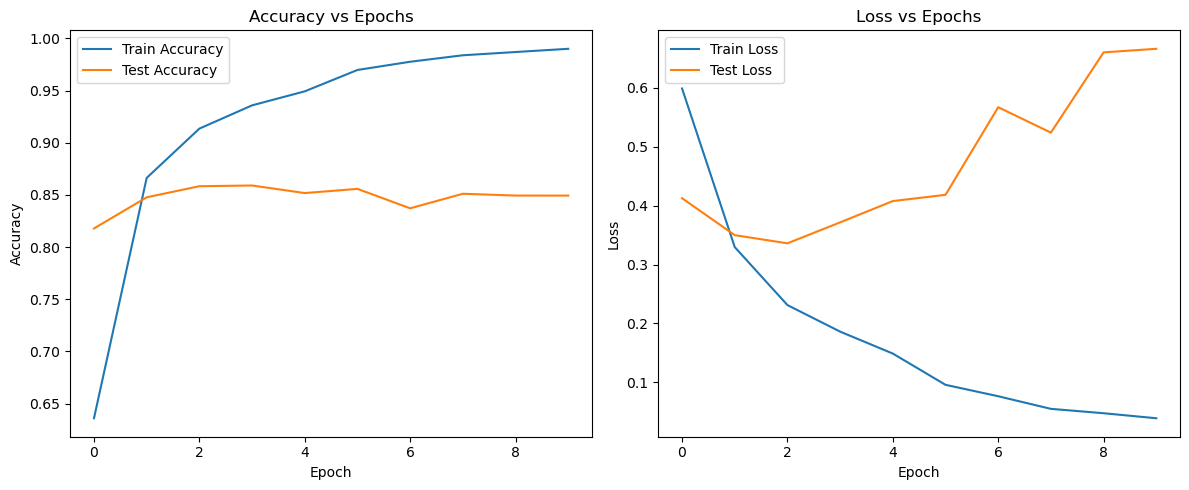

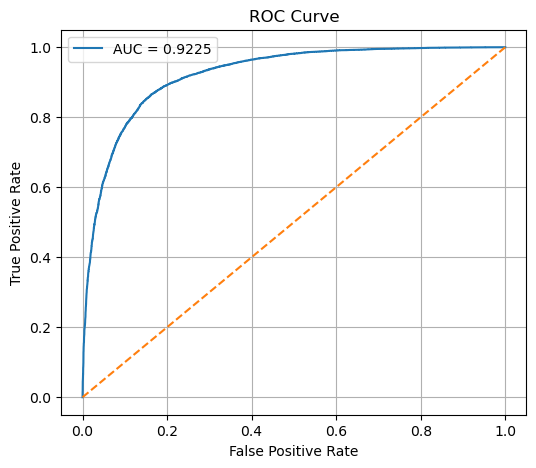

In [4]:
# ======= Improved LSTM Model =======
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.5):
        super(LSTM_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        
        # Bidirectional LSTM will have 2*hidden_dim features
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()
        
        # Initialize weights for better convergence
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]
        
        # LSTM forward pass
        output, _ = self.lstm(embedded)  # [batch, seq_len, 2*hidden_dim]
        
        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, 2*hidden_dim]
        
        # Apply dropout before final layer
        pooled = self.dropout(pooled)
        
        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
model = LSTM_Model(num_words, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# ======= Train & Evaluate =======
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        probs = model(x)
        loss = criterion(probs, y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist.append(test_acc)
    
    # Update scheduler based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# GRU Model

Epoch 1: Train Accuracy=0.6564, Test Accuracy=0.8225 | Train Loss=0.5811, Test Loss=0.3914
Epoch 2: Train Accuracy=0.8679, Test Accuracy=0.8334 | Train Loss=0.3237, Test Loss=0.3807
Epoch 3: Train Accuracy=0.9125, Test Accuracy=0.8598 | Train Loss=0.2297, Test Loss=0.3348
Epoch 4: Train Accuracy=0.9374, Test Accuracy=0.8559 | Train Loss=0.1731, Test Loss=0.4011
Epoch 5: Train Accuracy=0.9538, Test Accuracy=0.8564 | Train Loss=0.1374, Test Loss=0.4587
Epoch 6: Train Accuracy=0.9720, Test Accuracy=0.8537 | Train Loss=0.0893, Test Loss=0.5239
Epoch 7: Train Accuracy=0.9804, Test Accuracy=0.8488 | Train Loss=0.0710, Test Loss=0.4397
Epoch 8: Train Accuracy=0.9870, Test Accuracy=0.8348 | Train Loss=0.0509, Test Loss=0.6694
Epoch 9: Train Accuracy=0.9897, Test Accuracy=0.8455 | Train Loss=0.0418, Test Loss=0.6924
Epoch 10: Train Accuracy=0.9924, Test Accuracy=0.8457 | Train Loss=0.0330, Test Loss=0.6850

Final Evaluation on Test Set:
Accuracy : 0.8457
Precision: 0.8656
Recall   : 0.8184
F1 S

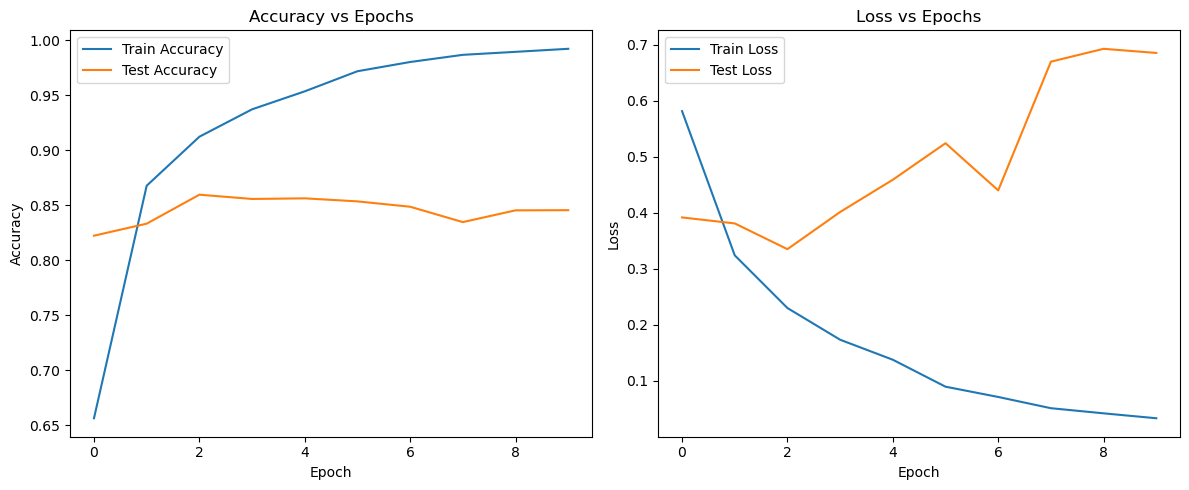

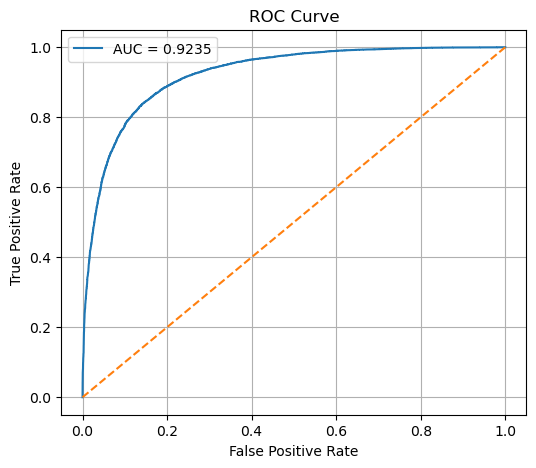

In [5]:
# ======= Improved GRU Model =======
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.5):
        super(GRU_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        
        # Bidirectional GRU will have 2*hidden_dim features
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()
        
        # Initialize weights for better convergence
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]
        
        # GRU forward pass
        output, _ = self.gru(embedded)  # [batch, seq_len, 2*hidden_dim]
        
        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, 2*hidden_dim]
        
        # Apply dropout before final layer
        pooled = self.dropout(pooled)
        
        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
model = GRU_Model(num_words, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# ======= Train & Evaluate =======
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        probs = model(x)
        loss = criterion(probs, y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist.append(test_acc)
    
    # Update scheduler based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Penjelasan Model, Visualisasi, dan Metrik

## 1. RNN (Recurrent Neural Network)

RNN menggunakan mekanisme **recurrence** untuk mengolah data urut seperti teks atau waktu. Formula utama yang digunakan dalam RNN adalah:

### Persamaan Dasar:
- **State Update**:
  $$
  h_t = f(W_h \cdot h_{t-1} + W_x \cdot x_t + b)
  $$
  - **Penjelasan**:
    - \($h_t$\): State tersembunyi pada waktu \(t\).
    - \($x_t$\): Input saat waktu \(t\).
    - \($W_h$\), \($W_x$\): Matriks bobot untuk state sebelumnya dan input saat ini.
    - \($b$\): Bias.
    - \($f$\): Fungsi aktivasi (contoh: tanh atau ReLU).

### Alur:
Pada setiap langkah waktu, RNN memperbarui state tersembunyi \($h_t$\) menggunakan input saat itu \($x_t$\) dan state sebelumnya \($h_{t-1}$\).

---

## 2. LSTM (Long Short-Term Memory)

LSTM mengatasi masalah **vanishing gradient** yang sering dialami RNN dengan menggunakan **gate mechanism**.

### Persamaan Dasar:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$
   - **Fungsi**: Memutuskan informasi mana yang harus dibuang dari memori.

2. **Input Gate**:
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C)
   $$
   - **Fungsi**: Menghitung memori baru yang akan ditambahkan.

3. **Cell State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   - **Fungsi**: Memperbarui state sel.

4. **Output Gate**:
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$
   - **Fungsi**: Menghitung keluaran berdasarkan state sel yang diperbarui.

---

## 3. GRU (Gated Recurrent Unit)

GRU adalah versi sederhana dari LSTM tanpa cell state terpisah. Persamaan yang digunakan:

### Persamaan Dasar:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
   $$
   - **Fungsi**: Memutuskan informasi masa lalu yang harus dilupakan.

2. **Update Gate**:
   $$
   z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
   $$
   - **Fungsi**: Mengontrol berapa banyak informasi dari masa lalu yang akan dibawa ke state saat ini.

3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$
   - **Fungsi**: State tersembunyi diperbarui menggunakan reset dan update gate.

---

## 4. Visualisasi

### Akurasi:
Akurasi dihitung sebagai:
$$
\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Sampel}}
$$

### Loss:
Loss dalam pelatihan model dihitung menggunakan fungsi **Binary Cross Entropy (BCE)**:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya.
- \($\hat{y}_i$\): Probabilitas prediksi model.

### ROC Curve:
ROC Curve menunjukkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**:
- **TPR**:
  $$
  TPR = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$
- **FPR**:
  $$
  FPR = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
  $$

### AUC (Area Under Curve):
AUC mengukur area di bawah ROC Curve:
$$
\text{AUC} = \int_{0}^{1} TPR(FPR) \,dFPR
$$
Nilai AUC berkisar antara 0 hingga 1, dengan 1 menunjukkan prediksi sempurna.

---

## 5. Metrik

### Precision:
Precision mengukur seberapa tepat model dalam prediksi kelas positif:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

### Recall:
Recall mengukur kemampuan model untuk mendeteksi semua kelas positif:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

### F1 Score:
F1 Score adalah rata-rata harmonis antara precision dan recall:
$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

# Penjelasan Matematika PyTorch

## 1. Embedding Layer
Layer **`nn.Embedding`** digunakan untuk mengubah input indeks menjadi representasi vektor yang dapat dipelajari:
$$
E(x_t) = W_{embedding} \cdot x_t
$$
- **Dimensi**:
  - \($x_t$\): Input berupa indeks kata, dengan dimensi \($(batch\_size, sequence\_length)$\).
  - \($W_{embedding}$\): Matriks bobot dengan ukuran \($(\text{vocab\_size}, \text{embed\_dim})$\).
  - Output: Tensor dengan dimensi \($(batch\_size, sequence\_length, \text{embed\_dim})$\).

PyTorch secara otomatis memperbarui \($W_{embedding}$\) selama pelatihan untuk menghasilkan representasi kata yang bermakna.

---

## 2. RNN, GRU, dan LSTM
### **a. RNN (`nn.RNN`)**
Recurrent Neural Network (RNN) digunakan untuk memproses data sekuensial. Persamaan matematisnya adalah:
$$
h_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$
- \($h_t$\): State tersembunyi pada waktu \($t$\).
- \($W_{ih}$\): Bobot input ke hidden state (\($\text{input\_dim}$ $\to$ $\text{hidden\_dim}$\)).
- \($W_{hh}$\): Bobot antara hidden state (\($\text{hidden\_dim}$ $\to$ $\text{hidden\_dim}$\)).
- \($b_h$\): Bias.
- Fungsi aktivasi: **tanh**.

Output RNN adalah state tersembunyi pada setiap langkah waktu.

---

### **b. GRU (`nn.GRU`)**
GRU menggunakan mekanisme gate untuk menangani vanishing gradient:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_{ir} \cdot x_t + W_{hr} \cdot h_{t-1} + b_r)
   $$
   - Mengontrol seberapa banyak informasi masa lalu yang dilupakan.
2. **Update Gate**:
   $$
   z_t = \sigma(W_{iz} \cdot x_t + W_{hz} \cdot h_{t-1} + b_z)
   $$
   - Mengontrol informasi baru yang ditambahkan ke state.
3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot (r_t \odot h_{t-1}) + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$

PyTorch menangani semua kalkulasi ini secara otomatis dalam layer GRU.

---

### **c. LSTM (`nn.LSTM`)**
LSTM memiliki struktur yang lebih kompleks dibanding GRU, dengan 3 jenis gate:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_{if} \cdot x_t + W_{hf} \cdot h_{t-1} + b_f)
   $$
2. **Input Gate**:
   $$
   i_t = \sigma(W_{ii} \cdot x_t + W_{hi} \cdot h_{t-1} + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_{ic} \cdot x_t + W_{hc} \cdot h_{t-1} + b_c)
   $$
3. **Output Gate**:
   $$
   o_t = \sigma(W_{io} \cdot x_t + W_{ho} \cdot h_{t-1} + b_o)
   $$
4. **State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$

Di PyTorch, `nn.LSTM` mengelola kedua state (\($h_t$\), \($C_t$\)) secara otomatis.

---

## 3. Dropout (`nn.Dropout`)
Layer `nn.Dropout` digunakan untuk regularisasi. Operasinya dapat dirumuskan sebagai:
$$
d_t = M \cdot h_t
$$
- \($M$\): Mask binari yang dihasilkan dengan probabilitas \($p$\) untuk dropout.

Dropout diaktifkan selama pelatihan (`model.train()`) tetapi tidak diterapkan saat evaluasi (`model.eval()`).

---

## 4. Fully Connected Layers (`nn.Linear`)
Layer `nn.Linear` adalah transformasi linier sederhana:
$$
y_t = W \cdot h_t + b
$$
- \($W$\): Matriks bobot (\($\text{hidden\_dim} \to \text{output\_dim}$\)).
- \($b$\): Bias.

Fungsi aktivasi seperti `ReLU` atau `Sigmoid` diterapkan setelah `nn.Linear` untuk menambahkan non-linearitas.

---

## 5. Binary Cross-Entropy Loss (BCELoss)
Loss dihitung menggunakan rumus:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya (0 atau 1).
- \($\hat{y}_i$\): Probabilitas prediksi setelah fungsi sigmoid.

---

## 6. GradScaler
PyTorch mendukung precision campuran dengan `torch.amp.GradScaler` untuk mencegah angka terlalu kecil atau besar:
- **Forward Pass**:
  $$ \text{loss} = \text{criterion}(output, label) $$
- **Gradient Scaling**:
  $$ \text{scaled\_loss} = \text{scale} \cdot \text{loss} $$
- Setelah backward pass:
  $$ \text{gradients} = \frac{\partial (\text{scaled\_loss})}{\partial (\text{parameters})} $$

Scaler memperbarui bobot sambil mempertahankan stabilitas numerik.

---

## 7. ReduceLROnPlateau
Scheduler ini mengurangi learning rate berdasarkan stagnasi pada loss validasi:
$$
\text{lr\_new} = \text{lr\_old} \times \text{factor}
$$
Dengan **PyTorch**:
```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)
scheduler.step(test_loss)
